What were the most common tags used to describe the trending videos?

In [28]:
from wordcloud import WordCloud

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
import calmap
import os
import csv

In [30]:
def read_files_by_country(dir_name, country_code):
    try:
        json_file = os.path.join(dir_name, f"{country_code}_category_id.json")
        csv_file = os.path.join(dir_name, f"{country_code}_youtube_trending_data.csv")

        with open(json_file, 'r', encoding='utf-8') as json_data:
            json_content = json.load(json_data)
            # print(f"Contents of {json_file}:")
            # print(json_content) 

        # for japanese
        # videos = pd.read_csv(csv_file, encoding="latin")
        videos = pd.read_csv(csv_file)
        # print(videos)

    except FileNotFoundError:
        print(f"Files for {country_code} not found.")
    
    return json_content, videos

country_code = 'IN'
json_content, videos = read_files_by_country('/Users/<USERID>/Desktop/Data/archive2023', country_code) 

In [31]:
videos['description'] = videos['description'].apply(lambda x: '' if pd.isnull(x)  else x)

##converting dates and times and creating a new column for publish time

videos['publishedAt'] = pd.to_datetime(videos['publishedAt'])
videos['trending_date'] = pd.to_datetime(videos['trending_date'])
videos.dropna(subset=['publishedAt'], inplace=True)
videos.dropna(subset=['trending_date'], inplace=True)
# videos.head()


videos['publish_date'] = videos['publishedAt'].dt.date
videos['publish_time'] = videos['publishedAt'].dt.time
videos['trending_date'] = videos['trending_date'].dt.date


##creating new column which has the time until the video begins to trend

json_df = pd.DataFrame(json_content['items'])
# Convert 'id' column to int64
json_df['id'] = json_df['id'].astype('int64')


# Extract 'title' from 'snippet' and assign it a name
json_df['category_title'] = json_df['snippet'].apply(lambda x: x['title'])

# Merge the DataFrames with the 'title' column
videos = videos.merge(json_df[['id', 'category_title']], left_on='categoryId', right_on='id')

# Drop the 'id' column from the merged DataFrame
videos = videos.drop(columns=['id'])

trending_repeat = videos.groupby(['video_id'])['category_title'].value_counts().reset_index(name='Trending Days')
# trending_repeat.head()

repeat_all = trending_repeat.pivot_table(index='Trending Days', columns='category_title', values='video_id', aggfunc='count').fillna(0)
# repeat_all

repeat_all_percentage = repeat_all.divide(repeat_all.sum(axis=1), axis=0) * 100
# repeat_all_percentage.head()

In [32]:
# calculate the number of trending days for each video
sort_trending = videos.groupby('video_id').size().reset_index(name='days_trending')
# drop duplicates
video_noduplicates = videos.drop_duplicates(subset='video_id', keep='first')
merge_videos = pd.merge(video_noduplicates, sort_trending, on='video_id')

merge_videos['trending_year'] = pd.to_datetime(merge_videos['trending_date']).dt.year
merge_videos['country'] = country_code
# sort the top 10 trending videos by trending days
top_trending = merge_videos.sort_values(by='days_trending', ascending=False).head(10)


C:\Users\19508\AppData\Local\Temp\ipykernel_19636\1594731673.py:34: UserWarning: Glyph 2980 (\N{TAMIL LETTER TA}) missing from current font.
  plt.tight_layout()
C:\Users\19508\AppData\Local\Temp\ipykernel_19636\1594731673.py:34: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
C:\Users\19508\AppData\Local\Temp\ipykernel_19636\1594731673.py:34: UserWarning: Glyph 2990 (\N{TAMIL LETTER MA}) missing from current font.
  plt.tight_layout()
C:\Users\19508\AppData\Local\Temp\ipykernel_19636\1594731673.py:34: UserWarning: Glyph 3007 (\N{TAMIL VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
C:\Users\19508\AppData\Local\Temp\ipykernel_19636\1594731673.py:34: UserWarning: Glyph 2996 (\N{TAMIL LETTER LLLA}) missing from current font.
  plt.tight_layout()
C:\Users\19508\AppData\Local\Temp\ipykernel_19636\1594731673.py:34: UserWarning: Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from current font.
  plt.tight_layout()
C:\Users\19508\AppData\Loca

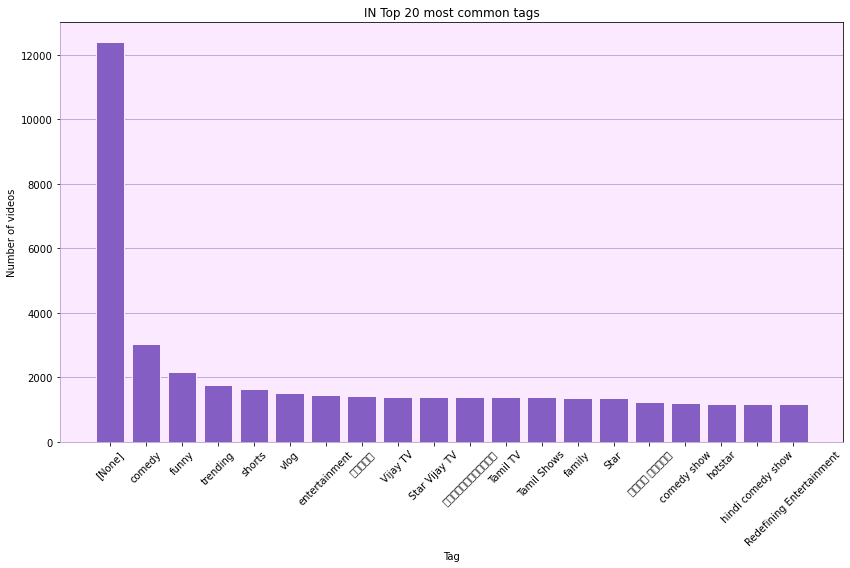

In [33]:
# Extract and count tags
all_tags = [tag.strip(' " ').strip() for sublist in merge_videos['tags'].str.split('|').tolist() for tag in sublist]
tag_counts = Counter(all_tags)

# Convert to DataFrame
top_tags_df = pd.DataFrame(tag_counts.most_common(20), columns=['Tag', 'Count'])
top_tags_df['%_count']=((top_tags_df['Count']/top_tags_df['Count'].sum())*100).round(2)

# plt.figure(facecolor='#845EC2')
fig, ax = plt.subplots(figsize=(12, 8))

# Set the rotation for the x-axis labels before creating the bar plot
plt.xticks(rotation=45,ha='center')  # Rotate x-axis labels for better visibility

# Create the bar plot
ax.bar(top_tags_df['Tag'], top_tags_df['Count'], color='#845EC2', edgecolor='#FBEAFF', linewidth=1)

#setting x/y axis line colour
ax.spines['left'].set_color('#B39CD0')
ax.spines['bottom'].set_color('#B39CD0')

#adjusting horizontal lines so that they are underneath bars
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#B39CD0')

#set title name and colour
ax.set_title(country_code + ' Top 20 most common tags')
# setting label names and colours
ax.set_xlabel('Tag')
ax.set_ylabel('Number of videos')

# Show the plot
ax.set_facecolor('#FBEAFF')
plt.tight_layout()
plt.show()
# plt.savefig(country_code + ' top20.png')

To conclude, in countries except India, people are more fond of funny videos, with categories such as 'funny', 'comedy' and 'humor'. Especially, in French and German, trending videos with no tags are most common. In comparison, Indian viewers show a distinct inclination towards television shows rather than favoring comedic content.

What words were used in top trending titles?


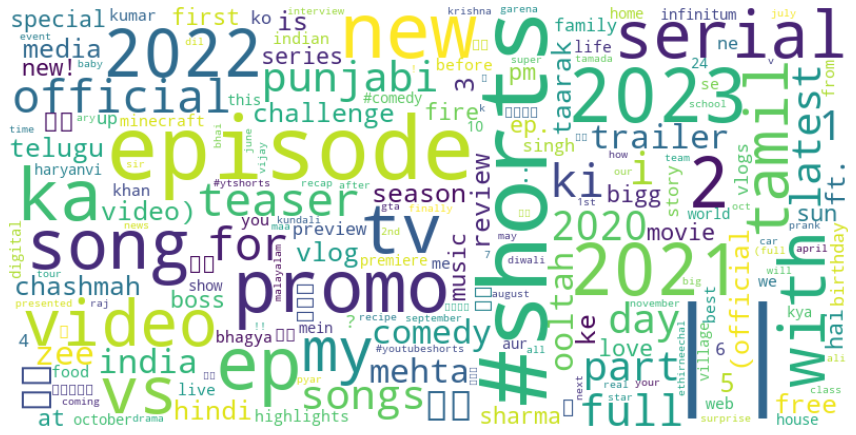

In [34]:

all_words = [word.strip().strip() for sublist in merge_videos['title'].str.split().tolist() for word in sublist]
# word_counts = Counter(all_words)
#convert all the words in word_counts to lowercase
word_counts = Counter(word.lower() for word in all_words)
to_remove = ['-','|','&','/','-', 'the', 'to', 'in', 'of', 'a', 'by', 'on', 'and']
for word in to_remove:
    word_counts.pop(word, None)
# 2. Convert to DataFrame
top_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])
top_words_df['%_count']=((top_words_df['Count']/top_words_df['Count'].sum())*100).round(2)


top_words_df = top_words_df[~top_words_df['Word'].isin(to_remove)]

# 3. Generate a word cloud using the word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Create a figure
plt.figure(figsize=(12, 8))

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('')

# Show the plot
plt.tight_layout()
plt.show()
# plt.savefig(country_code + ' wordcloud.png')


In the wordcloud image of the five countries, word '2018' is among all of them, showing a care of time from the trending videos.

Was there a standard length the was used for successful trending videos?

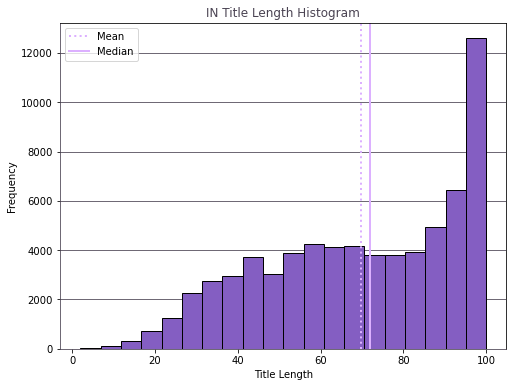

In [35]:
title_data = merge_videos['title'].apply(len)

fig, ax = plt.subplots(figsize=(8,6))

ax.hist(title_data,bins=20, color='#845EC2',edgecolor='black')

# Calculate mean and median
mean_value = np.mean(title_data)
median_value = np.median(title_data)

# Add a dotted line for the mean
ax.axvline(mean_value, color='#DCB0FF', linestyle='dotted', linewidth=2, label='Mean')

# Add a solid line for the median
ax.axvline(median_value, color='#DCB0FF', linestyle='solid', linewidth=2, label='Median')

# setting label names and colours
ax.set_xlabel('Title Length')
ax.set_ylabel('Frequency')

#setting x/y axis line colour
ax.spines['left'].set_color('#4B4453')
ax.spines['bottom'].set_color('#4B4453')

#adjusting horizontal lines so that they are underneath bars
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#4B4453')

#set background colour 
# ax.set_facecolor(colour_primary_black)
# fig.set_facecolor(colour_primary_black)

ax.set_title(country_code + ' Title Length Histogram',color='#4B4453')
plt.legend()

plt.show()
# plt.savefig(country_code + ' length.png')

Conclusion: In the five countries except India, trending videos' title lengths exhibit a distribution with smaller values at both ends and larger values in the middle. The most standard title lengths are around 50. However, India's video title shows a different pattern. Videos with longer titles are more likely to get popular, with mean and median value both around 70. Therefore, we can conclude that Indians prefer videos with longer titles.